### Imports

In [1]:
import numpy as np
from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis, val_test_split
from specmf.data import load_data
from specmf.plot import *

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

#### Data loading

In [3]:
dataset_name = "beam"

x_LF, x_HF = load_data(
    dataset_name,
    preprocess=True,
    normalize=False, 
    flatten=True,
)
# x_LF, x_HF = x_LF[:4000], x_HF[:4000]
print(f"{x_LF.shape=}", f"{x_HF.shape=}")

Loading beam data ...
x_LF.shape=(10000, 513) x_HF.shape=(10000, 513)


### Plot data 

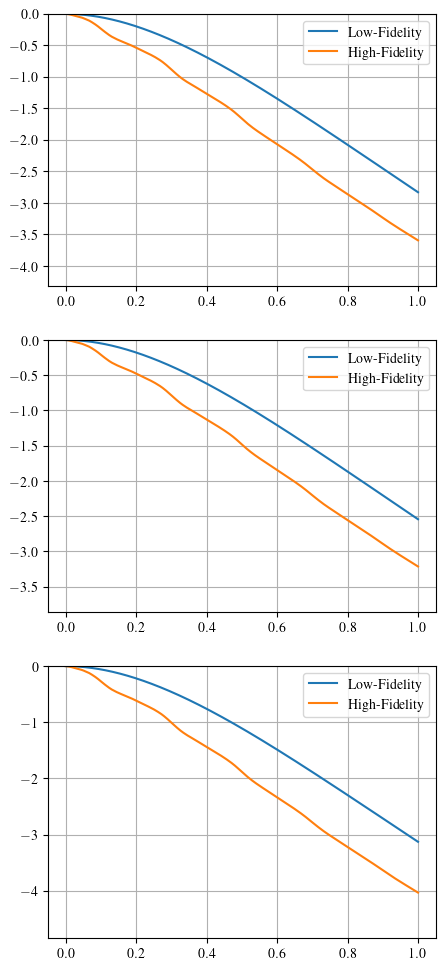

In [4]:
plot_data(x_LF, x_HF, dataset_name, n_samples=3)

### Multi-fidelity model

#### Create graph and model instances

In [5]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_LF, **graph_config)

# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'full'
}
model = MultiFidelityModel(**model_config)

#### Perform spectral clustering

In [6]:
n_HF = 50
inds_train, labels = model.cluster(g_LF, n_HF)

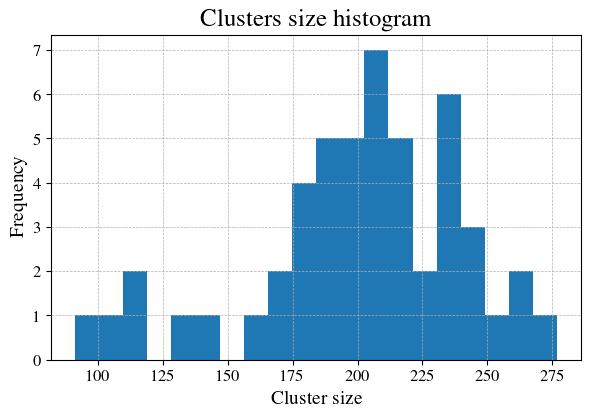

In [7]:
plot_cluster_size_hist(labels)

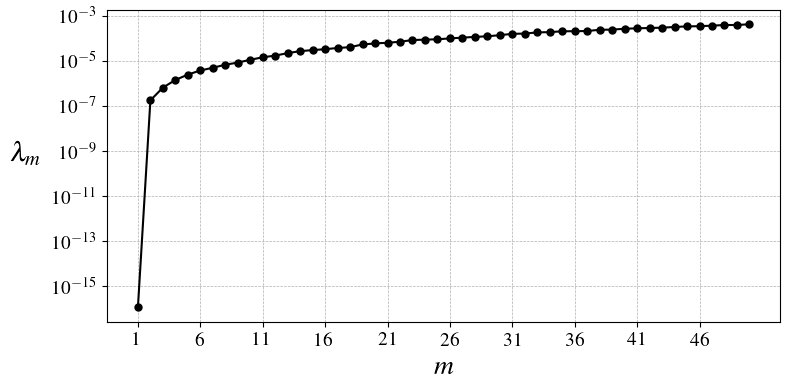

In [8]:
# Plot Laplacian spectrum
eigvals, eigvecs = g_LF.laplacian_eig()
plot_spectrum(eigvals, 50)

#### Split high-fidelity data

In [9]:
inds_val, inds_test = val_test_split(n_data=x_HF.shape[0], 
                                     inds_train=inds_train, 
                                     split_ratio=0.05)

x_HF_train = x_HF[inds_train, :]
x_HF_val = x_HF[inds_val, :]
x_HF_test = x_HF[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_val.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(50, 513) x_HF_val.shape=(497, 513) x_HF_test.shape=(9453, 513)


#### Hyper-parameters search

In [10]:
train = False

In [11]:
def cost_fn(kappa):
    """
    Custom cost function for the optimization.
    """
    # Create the model 
    model_config = {
        'sigma': 0.01,
        'method': 'full',
    }
    model = MultiFidelityModel(**model_config)

    model.kappa = kappa

    x_MF, _, dPhi = model.transform(g_LF, x_HF_train, inds_train)
    x_LF = g_LF.nodes
    _, e_MF = error_analysis(
        x_LF[inds_val],
        x_MF[inds_val],
        x_HF_val,
        return_values=True,
        verbose=0,
    )
    return np.mean(e_MF), np.mean(dPhi)


def train_loop(kappas):
    """
    Train the model for a range of kappa values.
    """
    errors = []
    dPhis = []
    for kappa in kappas:
        error, dPhi = cost_fn(kappa)
        errors.append(error)
        dPhis.append(dPhi)
    return errors, dPhis

In [12]:
if train:
    # Loop thru kappas
    kappas = np.logspace(-12, 5, 50)
    errors, dPhis = train_loop(kappas)

    # Find the optimal kappa
    ind_opt = np.argmin(np.abs(np.array(dPhis) - 3 * model_config["sigma"]))
    kappa_opt = kappas[ind_opt]
    print(f"Optimal kappa = {kappa_opt}")

    # Plots
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot the first set of data
    ax1.plot(kappas, errors , 'b-')
    ax1.set_xscale('log')
    ax1.set_xlabel(r'$\kappa$', fontsize=14)
    ax1.set_ylabel('error', color='b', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a twin axis sharing the same x-axis
    ax2 = ax1.twinx()

    # Plot the second set of data
    ax2.plot(kappas, dPhis, 'r-')
    ax2.set_yscale('log')
    ax2.set_ylabel(r'$\mathrm{mean}(\sqrt{C_{ii}})$', color='r', rotation=0, labelpad=50, fontsize=14)
    ax2.tick_params(axis='y', labelcolor='r')

    ax1.plot([kappa_opt, kappa_opt], [1, 30], 'k--')
    ax2.grid('on')

    plt.title('Beam data')

In [14]:
if not train:
    
    import yaml
    from pathlib import Path

    notebook_path = Path.cwd()
    yaml_file_path = notebook_path.parent / 'data/model_configs.yaml'
    with open(yaml_file_path, 'r') as file:
        MODEL_CONFIG = yaml.safe_load(file)

    kappa_opt = MODEL_CONFIG["beam"]["model_config"]["kappa"]
    print(f"Optimal kappa = {kappa_opt}")

Optimal kappa = 1.179e-06


#### Train the model with optimized hyperprameters

In [15]:
best_config = {
    'kappa': kappa_opt,
}

model_config.update(best_config)
model = MultiFidelityModel(**model_config)

In [16]:
x_MF, C_phi, dPhi = model.transform(g_LF, x_HF_train, inds_train)
model.summary()

Model Configuration:
sigma                   : 0.01
beta                    : 2
kappa                   : 1.179e-06
omega                   : 38532793.08276048
method                  : full
spectrum_cutoff         : None
tau                     : 1.7492088153795438e-07
n_clusters              : None
_is_graph_clustered     : False


Text(0.5, 1.0, 'Variance histogram Beam data')

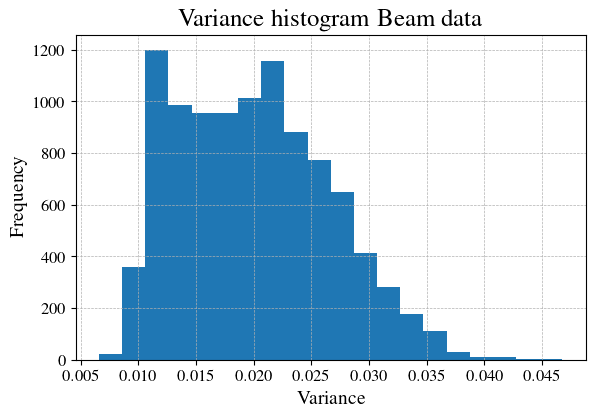

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(dPhi, bins=20)
ax.set_xlabel("Variance", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
ax.tick_params(axis="both", labelsize=12)
ax.set_title("Variance histogram Beam data", fontsize=18)

### Results

In [18]:
# Error Analysis for validation datadet
error_analysis(x_LF[inds_val], x_MF[inds_val], x_HF_val)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         30.73
Error MF:         4.39
Percentage drop:  85.72%


In [19]:
# Error Analysis for unseen test datadet
error_analysis(x_LF[inds_test], x_MF[inds_test], x_HF_test)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         30.7
Error MF:         4.46
Percentage drop:  85.48%


In [20]:
# Error Analysis for the whole dataset
error_analysis(x_LF, x_MF, x_HF)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         30.7
Error MF:         4.43
Percentage drop:  85.56%


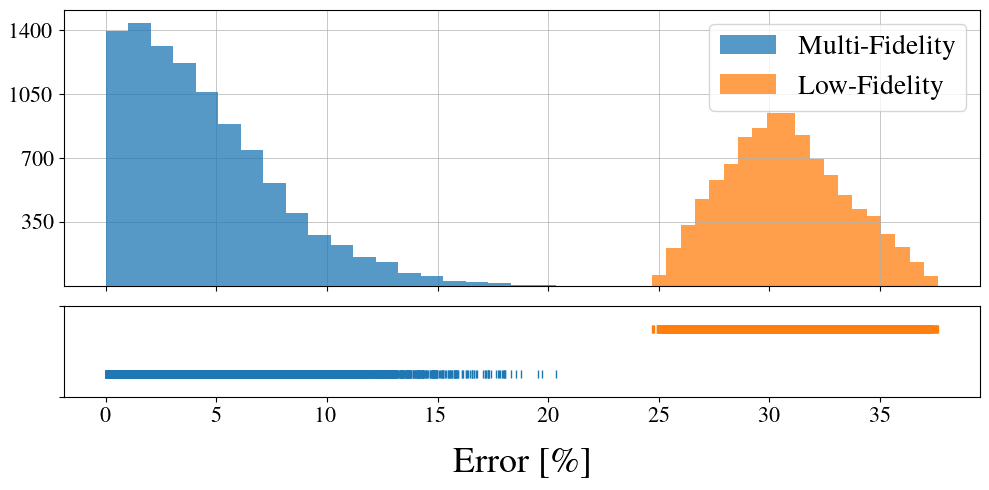

In [21]:
E_LF = 100 * np.linalg.norm(x_LF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)
E_MF = 100 * np.linalg.norm(x_MF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)

plot_distributions(E_LF, E_MF, bins_LF=20, bins_MF=20, mask=None)

In [23]:
# plot_mf_comparison(x_LF, x_MF, x_HF, dataset_name, dPhi=dPhi, inds_centroids=inds_train)

In [24]:
def _plot_mf_comparison_curves(X_LF: np.ndarray,
                               X_MF: np.ndarray,
                               X_HF: np.ndarray,) -> None:
    n_points, _ = X_LF.shape
    fig, axs = plt.subplots(2, 2, figsize=(12.5, 8))
    fig.subplots_adjust(wspace=0.075, hspace=0.075)

    for r in range(2):
        for c in range(2):
            j = np.random.randint(0, n_points)
            vmin, vmax = 1.2 * np.min((X_LF[j, :], X_HF[j, :])), 1.2 * np.max((X_LF[j, :], X_HF[j, :]))
            x_ = np.linspace(0, 1, X_LF[j, :].shape[0])
            axs[r, c].plot(x_, X_MF[j, :], label="Multi-Fidelity")
            axs[r, c].plot(x_, X_LF[j, :], label="Low-Fidelity")
            axs[r, c].plot(x_, X_HF[j, :], label="High-Fidelity")
            axs[r, c].set_ylim([vmin, vmax])
            axs[r, c].grid('on')
            axs[r, c].set_ylim([-4.5, 0])
            if c == 1:
                axs[r, c].set_yticklabels([])
            if r == 1:
                axs[r, c].set_xlabel(r"$x$", fontsize=18)
            if c == 0:
                axs[r, c].set_ylabel(r"$w(x)$", rotation=0, fontsize=18, labelpad=20)
            if r == 0:
                axs[r, c].set_xticklabels([])

    axs[1, 1].legend(loc='lower left', fontsize=14)

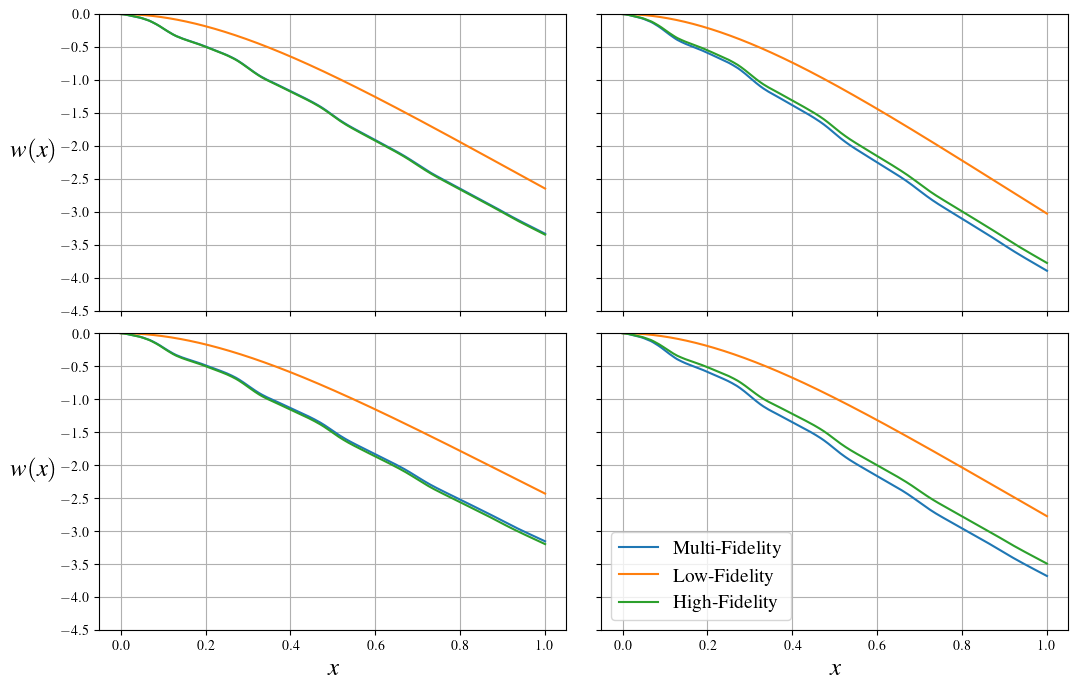

In [27]:
_plot_mf_comparison_curves(x_LF, x_MF, x_HF)

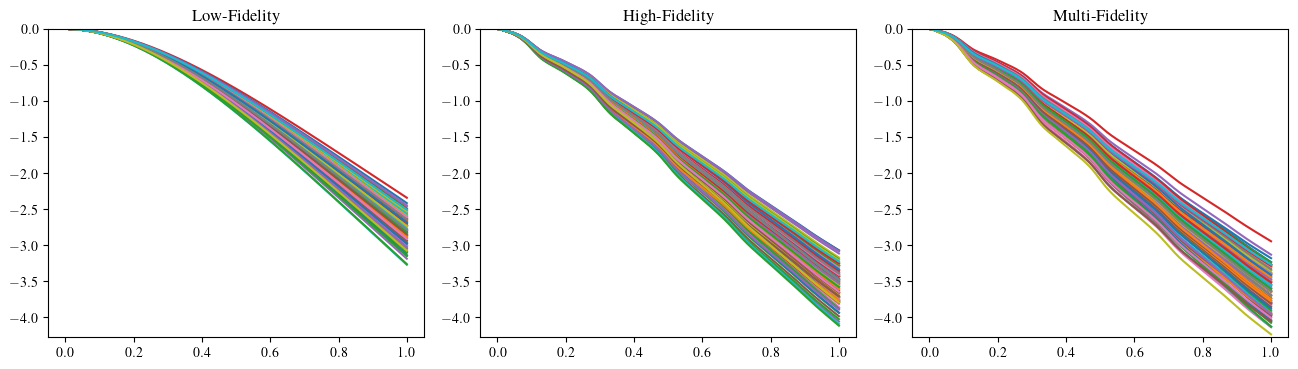

In [29]:
n_points, _ = x_LF.shape
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.subplots_adjust(wspace=0.15)
vmin, vmax = 1. * np.min((x_LF, x_HF)), 1.2 * np.max((x_LF, x_HF))
for i in range(100):
    j = np.random.randint(0, n_points)
    x_ = np.linspace(0, 1, x_LF[j, :].shape[0])
    axs[0].plot(x_, x_LF[j, :], label="Low-Fidelity")
    axs[0].set_title("Low-Fidelity")
    axs[1].plot(x_, x_HF[j, :], label="High-Fidelity")
    axs[1].set_title("High-Fidelity")
    axs[2].plot(x_, x_MF[j, :], label="Multi-Fidelity")
    axs[2].set_title("Multi-Fidelity")
    axs[0].set_ylim((vmin, vmax))
    axs[1].set_ylim((vmin, vmax))
    axs[2].set_ylim((vmin, vmax))

### Explore UQ applications

In [25]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

correlation = 0.19066299904192577


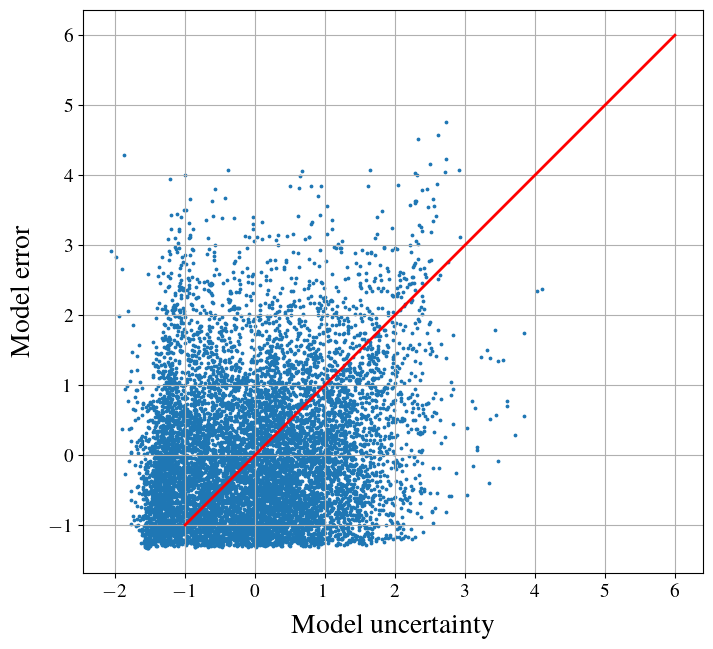

In [26]:
# Plot error vs model uncertainty
import scipy.stats

y_ = np.linalg.norm(x_MF - x_HF, axis=1)
x_ = dPhi

mask_ = (y_ < 15) 
x_, y_ = x_[mask_], y_[mask_]

x = (x_ - np.mean(x_)) / np.std(x_)
y = (y_ - np.mean(y_)) / np.std(y_)

corr, _ = scipy.stats.pearsonr(x, y)
print(f"correlation = {corr}")

x_plot = np.linspace(-1, 6, 10).reshape(-1, 1)
y_plot = x_plot

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(x, y, s=3)
ax.set_aspect('equal', 'box')
ax.plot(x_plot, y_plot, c='r', linewidth=2)
ax.set_xlabel('Model uncertainty', fontsize=20, labelpad=10)
ax.set_ylabel('Model error', fontsize=20, labelpad=10)
ax.tick_params(axis='both', labelsize=14)
ax.grid("on")

In [27]:
_, eigevs = g_LF.laplacian_eig()
X = np.real(eigvecs[:, :n_HF])

In [28]:
import umap

X_umap = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=1,
    init='random', 
    random_state=42
).fit_transform(X)

/opt/homebrew/Caskroom/miniforge/base/envs/generic-env/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'UMAP of Cantilever Beam data (Case 4)')

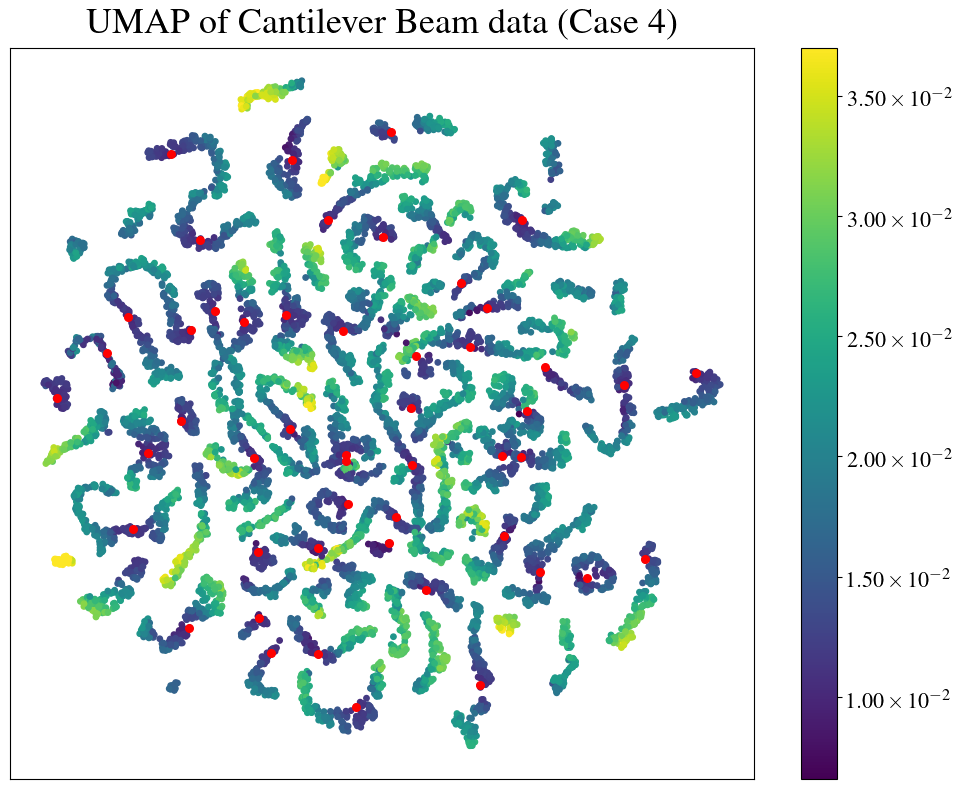

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9.5))
ax1 = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=15, c=dPhi, vmax=0.037)
ax.scatter(X_umap[inds_train, 0], X_umap[inds_train, 1], s=30, c='r', marker='o')
cb = plt.colorbar(ax1, format=ticker.FuncFormatter(fmt))
cb.ax.tick_params(labelsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of Cantilever Beam data (Case 4)', fontsize=26, pad=10)

In [ ]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2,
              init='random',
              random_state=42,
              perplexity=50,
              early_exaggeration=2,).fit_transform(X)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9.5))
ax1 = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], s=15, c=dPhi)
ax.scatter(X_tsne[inds_train, 0], X_tsne[inds_train, 1], s=30, c=dPhi[inds_train], marker='o')
cb = plt.colorbar(ax1, format=ticker.FuncFormatter(fmt))
cb.ax.tick_params(labelsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('t-SNE of Beam data', fontsize=26, pad=10)